In [25]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
###NOTE: A few things may be repeated and may not be consistent in this code file, however that
### because this was intended for use on Jupyter notebook.




In [26]:
#takes the position of two masses and outputs the vector difference, and the modulus
def vectorise(x1,y1,x2,y2):
    v = np.array([x2-x1,y2-y1])
    return v, np.linalg.norm(v)

#gives the angle between two vectors
def angle(v1,v2):    
  return np.arccos(np.dot(v1,v2)*(1/np.sqrt(np.dot(v1,v1))) *(1/np.sqrt(np.dot(v2,v2))))

In [27]:
#this is the function required to give derivatives for all variables, to input into ODE solver
def derivatives(y,t):
    G =4*np.pi**2
    
    Ms = 1

    #Vij gives the vector pointing from i to j (leading to force on j from i)
    Vjs = vectorise(y[2],y[3],y[0],y[1])
    Vsg = vectorise(y[0],y[1],y[4],y[5])
    Vjg = vectorise(y[2],y[3],y[4],y[5])
    Vst = vectorise(y[0],y[1],y[6],y[7])
    Vjt = vectorise(y[2],y[3],y[6],y[7])

    #outputs array with the derivative of each variable
    return [y[8],y[9],#first differentials of sun position
    y[10],y[11],#first differentials of Jupiter position
    y[12],y[13],#first differentials of Greek position
    y[14],y[15], #first differentials of Trojan position
            
    -G*Mj*1/(Vjs[1]**3) *Vjs[0][0], #derivative of suns x vel
    -G*Mj*1/(Vjs[1]**3) *Vjs[0][1], #derivative of suns y vel
    
    G*Ms*1/(Vjs[1]**3) *Vjs[0][0], #derivative of Jupiter x vel
    G*Ms*1/(Vjs[1]**3) *Vjs[0][1], #derivative of jupiters y vel
    
    -G*(Ms*1/(Vsg[1]**3) * Vsg[0][0] + Mj*1/(Vjg[1]**3) * Vjg[0][0]), #derivative of greek x vel
    -G*(Ms*1/(Vsg[1]**3) * Vsg[0][1] + Mj*1/(Vjg[1]**3) * Vjg[0][1]), #derivative of greek y vel
    
    -G*(Ms*1/(Vst[1]**3) * Vst[0][0] + Mj*1/(Vjt[1]**3) * Vjt[0][0]), #derivative of trojan x vel
    -G*(Ms*1/(Vst[1]**3) * Vst[0][1] + Mj*1/(Vjt[1]**3) * Vjt[0][1])] #derivative of trojan y vel

In [28]:

def solver(t, d , ang_dev , d_dev , v_dev):
    #t is the number of years to run simulation for
    #Use v^2 = GM/R where here, R is given by d  
    #also have three variables, ang_dev d_dev and v_dev, denoting the angle and distance deviation and velocity deviation
    #to make from ideal for the asteroids. This requires a new velocity, v_ast 
    v = np.sqrt(4*np.pi**2 /d)
    v_ast = np.sqrt(4*np.pi**2 /(d_dev+ d )) + v_dev

    return scipy.integrate.odeint(
        func = derivatives,
        t=np.arange(0,t,0.05),
        # initial velocities are given in sun frame, and are in AU/year, distances in AU (1AU = 1.496 *10^11 m)
        y0 = (0, 0,  #initial values of y[0-1]; sun position
        0, d,  #initial values of y[2-3] jupiter position
        -(d+d_dev)*np.cos(np.pi/6 +ang_dev), (d+d_dev)*np.sin(np.pi/6 +ang_dev), #initial values of y[4-5]; greek position
        (d+d_dev)*np.cos(np.pi/6 +ang_dev), (d+d_dev)*np.sin(np.pi/6 +ang_dev) , #initial values of y[6-7]; trojan position
        0,0, #initial values of y[8-9]; sun velocity
        v, 0, #initial values of y[10-11]; jupiter velocity in AU per year
        v_ast*np.sin(np.pi/6 +ang_dev), v_ast*np.cos(np.pi/6 +ang_dev), #initial values of y[12-13]; greek velocity in AU per year
        v_ast*np.sin(np.pi/6 +ang_dev), -v_ast*np.cos(np.pi/6 +ang_dev)),#initial values of y[14-15]; trojan velocity in AU per year
    )
    # solution # Outputs t by 16 matrix, each collum represents y[i]'s evolution through time

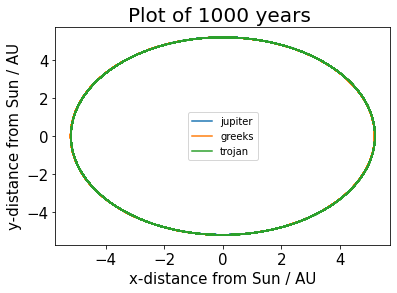

In [29]:
#now run the program and test if it outputs the correct orbital shape

Mj = 0.001
G = 4*np.pi**2
t = 1000
step = 0.05
sol = solver(t,5.2, 0 , 0 , 0)

#plot the test orbit:

plt.plot(sol[:,2]-sol[:,0],sol[:,3]-sol[:,1], label = 'jupiter')
plt.plot(sol[:,4]-sol[:,0],sol[:,5]-sol[:,1], label = 'greeks')
plt.plot(sol[:,6]-sol[:,0],sol[:,7]-sol[:,1], label = 'trojan')
plt.title(f'Plot of {t} years ',size = 20)
plt.xlabel('x-distance from Sun / AU', size = 15)
plt.ylabel('y-distance from Sun / AU', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend()
plt.show()

In [30]:
%timeit solver(1000,5.2,0,0,0)

1 loop, best of 5: 851 ms per loop


In [31]:
## energy and angular momentum conservation   G*Mj*1/(np.dot(x,x)**1.5)

In [32]:
#create vectors for the position and velocity of jupiter with time
N = len(sol[:,3])
x_j = [sol[:,2]-sol[:,0],sol[:,3]-sol[:,1]]
v_j = [sol[:,10]-sol[:,8],sol[:,11]-sol[:,9]]


dEdt = np.zeros(N)
J = np.zeros(N)
for i in range(N):
  x = np.array([x_j[0][i],x_j[1][i],0])
  v = np.array([v_j[0][i],v_j[1][i],0])
  
  a_j = G*Mj*1/(np.dot(x,x)**1.5)*x

  #now create values for energy and J derivatives. Could be vectorised
  dEdt[i] = Mj*np.dot(v,a_j) - G*Mj*1/(np.dot(x,x)**1.5)*np.dot(x,v)
  J[i]=np.linalg.norm(np.cross(x,Mj*a_j))


Text(0.5, 1.0, '400 years')

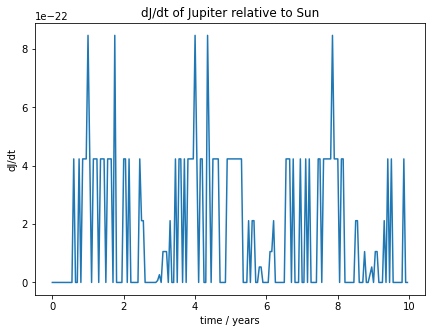

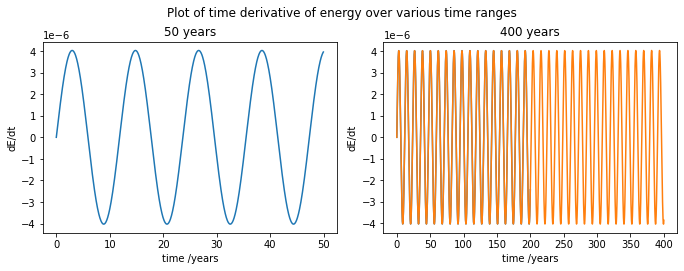

In [33]:
#create time array for plotting 
time_array = np.linspace(0,t,N)



plt.figure(figsize = [7,5])
plt.plot(time_array[:200],J[:200])
plt.title('dJ/dt of Jupiter relative to Sun')
plt.xlabel('time / years')
plt.ylabel('dJ/dt')

time_array = np.linspace(0,t,N)

fig = plt.figure(figsize=(10,4))
plt.tight_layout()
fig.suptitle("Plot of time derivative of energy over various time ranges")
ax = plt.subplot("121")
ax.set_title("50 years")
ax.plot(time_array[:1000], dEdt[:1000])
ax.set_xlabel('time /years')
ax.set_ylabel('dE/dt')
ax = plt.subplot("122")
ax.set_title("200 years")
ax.plot(time_array[:4000], dEdt[:4000]) 
ax.set_xlabel('time /years')
  
plt.tight_layout(pad=2.5)

plt.plot(time_array[:8000], dEdt[:8000])
plt.xlabel('time /years')
plt.ylabel('dE/dt')
plt.title('400 years')


In [34]:
#### Measuring wander

In [35]:
N = int(t/step)



modulus_array = np.zeros(N)
angle_array = np.zeros(N)
for i in range(N):
  
    #create vectors to Jupiter and asteroid, and create a relative vector
    a = np.array([sol[i,2]-sol[i,0],sol[i,3]-sol[i,1]])
    b = np.array([sol[i,4]-sol[i,0],sol[i,5]-sol[i,1]])
    c = a - b
    #create array giving Jupiter-Greek distance and angle with time
    angle_array[i] =  angle(a,b)
    modulus_array[i] = np.linalg.norm(c)

    
#convert angle to degrees
angle_array = angle_array*180/np.pi -60
#find distance away from lagrange point
modulus_array = modulus_array - modulus_array[0]

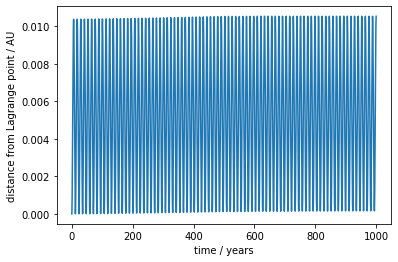

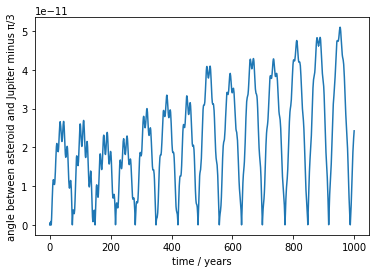

In [36]:
#plotting the wander
time_array = np.arange(0,t,step)

plt.plot(time_array[:],np.abs(modulus_array[:]))
plt.xlabel('time / years')
plt.ylabel('distance from Lagrange point / AU')
plt.show()
#
plt.plot(time_array[:],np.abs((angle_array[:])))
plt.xlabel('time / years')
plt.ylabel('angle between asteroid and Jupiter minus π/3')
plt.show()


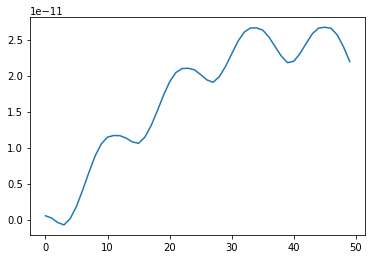

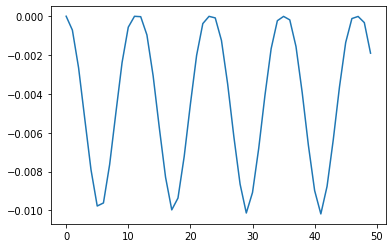

In [37]:
#wander_points is the number of sample points we use to investigate the wander
wander_points = 50

#
max_array = np.zeros(wander_points)

max_array_cum = np.zeros(wander_points)

wander_modulus_array = np.zeros(wander_points)
for i in range(wander_points):

    #finds maximum angle between J and G in the intervals
    max_array[i] = np.max(angle_array[int(i*t/wander_points):int((i+1)*t/wander_points)])
    #finds maximum distance between J and G in the intervals
    wander_modulus_array[i] = np.max(modulus_array[int(i*t/wander_points):int((i+1)*t/wander_points)])

plt.plot(np.arange(wander_points),max_array)
plt.show()
plt.plot(np.arange(wander_points),wander_modulus_array)
plt.show()

In [38]:
### Mass perturbation

In [39]:
#function to find maximum wander given initial condition perturbations
def wander_finder_cum(  t ,  ang_dev, d_dev, v_dev):
  step = 0.05
  N = int(t/step)
  
  sol = solver(t,5.2, ang_dev , d_dev , v_dev)

  modulus_array = np.zeros(N)
  angle_array = np.zeros(N)
  for i in range(N):
    
    a = np.array([sol[i,2]-sol[i,0],sol[i,3]-sol[i,1]])
    b = np.array([sol[i,4]-sol[i,0],sol[i,5]-sol[i,1]])
    c = a - b

    angle_array[i] =  angle(a,b)
    modulus_array[i] = np.linalg.norm(c)
    
  #convert angle to degrees
  angle_array = angle_array*180/np.pi -60
  time_array = np.arange(0,t,step)

  #minus the initial distance from modulus array, and square, just in case the deviations
  #are negative
  modulus_array =  (modulus_array - modulus_array[0])**2
  
  return np.amax(angle_array) , np.amax(modulus_array)

In [40]:
#array containing masses to iterate over to find maximum deviation
masses = np.array([0.0001*3*i for i in range(2)]+[0.001+0.002*i for i in range(13)])
number_of_values = np.size(masses)
wander_angles_for_masses = np.zeros(number_of_values)
wander_modulus_for_masses = np.zeros(number_of_values)

for i in range(number_of_values):
  Mj = masses[i]
  a , b = wander_finder_cum(1000,0,0,0)
  wander_angles_for_masses[i] = a
  wander_modulus_for_masses[i] = b

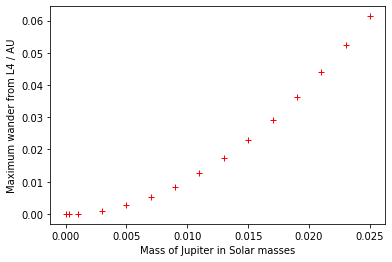

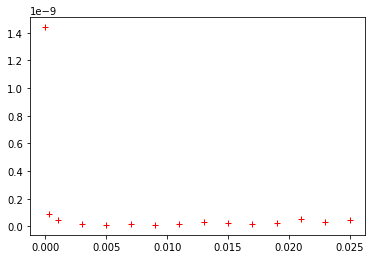

In [41]:
#create graph of maximum wander for a given mass
plt.plot(masses, wander_modulus_for_masses, 'r+')
plt.xlabel('Mass of Jupiter in Solar masses')
plt.ylabel('Maximum wander from L4 / AU')
plt.show()
plt.plot(masses, wander_angles_for_masses, 'r+')
plt.show()


In [42]:
### Radius Perturbation

In [43]:
def wander_finder_from_deviation(  t ,  ang_dev, d_dev, v_dev):
  step = 0.05
  N = int(t/step)
  #wander_points is the number of sample points we use to investigate the wander
  wander_points = t
  sol = solver(t,5.2, ang_dev , d_dev , v_dev)

  modulus_array = np.zeros(N)
  angle_array = np.zeros(N)
  for i in range(N):
    
    a = np.array([sol[i,2]-sol[i,0],sol[i,3]-sol[i,1]])
    b = np.array([sol[i,4]-sol[i,0],sol[i,5]-sol[i,1]])
    c = a - b

    angle_array[i] =  angle(a,b)
    modulus_array[i] = np.linalg.norm(c)
    
  #convert angle to degrees
  angle_array = angle_array*180/np.pi -60
  time_array = np.arange(0,t,step)

  #minus the initial distance from modulus array (global variable)
  modulus_array =  (modulus_array - 5.2)
  #create arrays to store wander values
  wander_angle_array = np.zeros(wander_points)
  wander_modulus_array = np.zeros(wander_points)
  for i in range(wander_points):
    wander_angle_array[i] = np.max(angle_array[int(i*t/wander_points):int((i+1)*t/wander_points)])
    wander_modulus_array[i] = np.max(modulus_array[int(i*t/wander_points):int((i+1)*t/wander_points)])
  #return maximum wanders 
  return np.amax(wander_angle_array) , np.amax(wander_modulus_array)

In [44]:
#create arrays of wander for given radius perturbation
Mj = 0.001
radii = np.array([0.0001+ i*0.005 for i in range(10)])
number_of_values = np.size(radii)
wander_angles_for_radii = np.zeros(number_of_values)
wander_modulus_for_radii = np.zeros(number_of_values)

for i in range(number_of_values):
  #find wander for given radii
  a , b = wander_finder_from_deviation(2000,0,radii[i],0)
  wander_angles_for_radii[i] = a
  wander_modulus_for_radii[i] = b


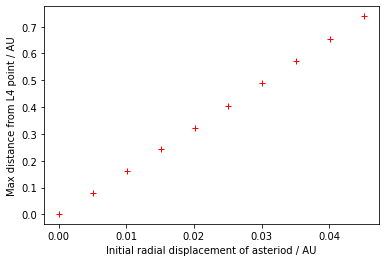

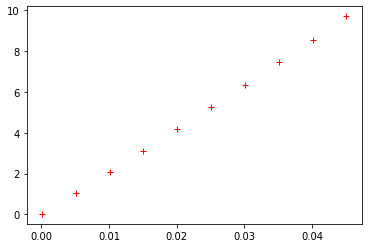

In [45]:
#plot wander for given radii
plt.plot(radii, wander_modulus_for_radii, 'r+')
plt.xlabel('Initial radial displacement of asteriod / AU')
plt.ylabel('Max distance from L4 point / AU')
plt.show()
plt.plot(radii, wander_angles_for_radii, 'r+')
plt.xlabel('Initial radial displacement of asteriod / AU')
plt.ylabel('Max angle from L4 /')
plt.show()


In [46]:
### Velocity Perturbation

In [23]:
Mj = 0.001
#create array of velocity perturbation to investigate wander with
vels = np.array([0.0001+ i*0.005 for i in range(10)])
number_of_values = np.size(vels)
wander_angles_for_vels = np.zeros(number_of_values)
wander_modulus_for_vels = np.zeros(number_of_values)

for i in range(number_of_values):
  
  a , b = wander_finder_from_deviation(5000,0,0,vels[i])
  wander_angles_for_vels[i] = a
  wander_modulus_for_vels[i] = b

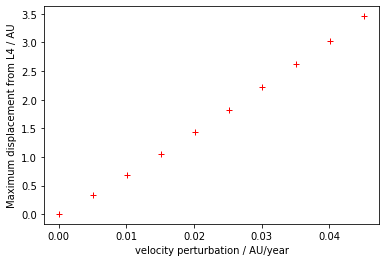

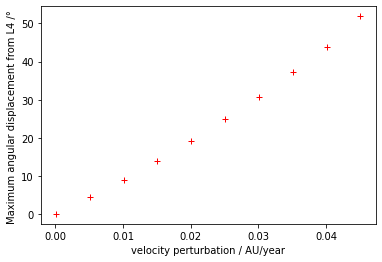

In [24]:
#plot wander for given velocity perturbation
plt.plot(vels, wander_modulus_for_vels, 'r+')
plt.xlabel('velocity perturbation / AU/year')
plt.ylabel('Maximum displacement from L4 / AU')
plt.show()
plt.plot(vels, wander_angles_for_vels, 'r+')
plt.xlabel('velocity perturbation / AU/year')
plt.ylabel('Maximum angular displacement from L4 /° ')
plt.show()